In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
from helper import *

%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()

plate_select = [792,1014,1042,127,130,1023,1045,1053,1048,52,84,938,1076,94,152,102,76,3,12,16,480,91,799,800] #C2
plates = ['1014_20220525', '1023_20220502',
          # '102_20201226',
          '1042_20220523',
       '1045_20220504', '1048_20220506',
          # '1053_20220413',
          '1076_20220511',
       # '127_20220705',
          '152_20201224',
          "3_20220426", "12_20220502","16_20220419","480_20221205", '52_20220707',
          '76_20210108',
       '792_20210915', '799_20211001', '800_20210928',
          '84_20220621', '91_20220708', '938_20220325',
          '94_20201123'
         ]
plates += ["28_20230227",
"206_20230303",
"202_20230314",
"218_20230227",
"219_20230307",
"229_20230330",]
# plates += [
# "850_20230511",
# "840_20230404",
# "861_20230411"
# ]
plates += ["527_20230106","537_20230111"]
plates += ["462_20221013"]
plates += ["532_20220104"]
plates += [
"249_20230324",
"241_20230403",
"252_20230316",
"248_20230320",
]
# plates += ['464_20230807','474_20230807','470_20230709']

# plates += ['439_20230804','420_20230705','416_20230705']
# plates += ['443_20230720','436_20230717']
# plates += ['431_20230627']
plates += ["510_20221201","521_20230104","530_20230115"]
plates += [
        "559_20230109", 

          # "545_20220115",
          "544_20230109",
          "531_20221222",
]
plates += [
    # "522_20230115",
         "514_20221206",
         "513_20221205",
         "506_20221124",
         # "503_20221124",
         "472_20221003"
          ]
plates += [
          "558_20230109",
          "552_20230111",
          "551_20220102",
          "540_20221227",
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
# folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,False)
# folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,False)
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100,206 : 90,202 : 100,218 : 100,219 :100,229 :100}
timestep2 = {431:20}
timestep = {**timestep, **timestep2}
for j in range(0,len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    if not plate in timestep.keys():
        timestep[plate] = 100
ncols = 3

time_plate_info = time_plate_info.replace(-1.0,np.nan)

# fig,axs = gridplot(len(plates)+1,ncols = ncols,subh = 3,subw = 3)
# ax_list = list(axs)
plate_speeds = {}
for j in range(0,len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    # ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)]
    time_plate_info_plate = time_plate_info_plate.loc[time_plate_info_plate['timestep']<timestep[plate]]
    # ax.plot(time_plate_info_plate['time_since_begin_h'],time_plate_info_plate['hull_speed'],
    #                 color="black")
    # ax.set_title(plate_id)
    plate_speeds[plate_id] = np.nanmedian(time_plate_info_plate['hull_speed'])
time_plate_info["density"] = time_plate_info["tot_length_study"]/time_plate_info["area_sep_comp"]
time_plate_info["density_biovolume"] = time_plate_info["tot_biovolume_study"]/time_plate_info["area_sep_comp"]
time_plate_info["density_SA"] = time_plate_info["tot_surface_area_study"]/time_plate_info["area_sep_comp"]
time_plate_info = time_plate_info.replace(-1.0,np.nan)

# fig,axs = gridplot(len(plates)+1,ncols = ncols,subh = 3,subw = 3)
# ax_list = list(axs)
plate_density = {}
plate_density_biov = {}
plate_radius = {}
plate_radius_SA = {}

plate_SA_density = {}

fungalC = {}

plate_strain = {}
plate_start = {}
root = {}
for j in range(0,len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    # ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)]
    folders_plate = folders.loc[folders['unique_id']==int(plate_id)]
    time_plate_info_plate = time_plate_info_plate.loc[time_plate_info_plate['timestep']<timestep[plate]]
    # ax.plot(time_plate_info_plate['time_since_begin_h'],np.sqrt(time_plate_info_plate['density']),
    #                 color="black")
    # ax2 = ax.twinx()
    # ax2.plot(time_plate_info_plate['time_since_begin_h'],time_plate_info_plate['density']/time_plate_info_plate['density_biovolume'],
    #                 color="red")
    time_plate_info_plate_median = time_plate_info_plate.loc[time_plate_info_plate['timestep']>=min(max(time_plate_info_plate['timestep']),timestep[plate]-10)]

    plate_density[plate_id] = np.nanmedian(time_plate_info_plate_median['density'])
    plate_density_biov[plate_id] = np.nanmedian(time_plate_info_plate_median['density_biovolume']) 
    plate_radius[plate_id] = np.nanmedian(np.sqrt(time_plate_info_plate_median['density_biovolume']/time_plate_info_plate_median['density']/np.pi)) 
    plate_radius_SA[plate_id] = np.nanmedian(time_plate_info_plate_median['density_SA']/time_plate_info_plate_median['density']/(2*np.pi)) 
    
    plate_strain[plate_id] = folders_plate['strain'].iloc[0]
    plate_start[plate_id] = folders_plate['CrossDate'].iloc[0]
    fungalC[plate_id] = folders_plate['fungalC'].iloc[-1]
    root[plate_id] = folders_plate['root'].iloc[-1]
    
    plate_SA_density[plate_id] = np.nanmedian(time_plate_info_plate_median['density_SA'])
    # ax.set_title(plate_id)
    # break
df = pd.DataFrame({
    'plate_id': list(plates),
    'start': [plate_start[x] for x in plates],
    'speed': [plate_speeds[x] for x in plates],
    'density_SA': [plate_SA_density[x] for x in plates],
    'density_BV': [plate_density_biov[x] for x in plates],
    'density_L': [plate_density[x] for x in plates],
    
    'radius': [plate_radius[x] for x in plates],
    'radius_SA': [plate_radius_SA[x] for x in plates],
    
    'strain': [plate_strain[x] for x in plates],
    'fungalC': [fungalC[x] for x in plates],
    'root': [root[x] for x in plates],
    
    
})
df['strain'] = df['strain'].replace("'A5sp3'","'A5'")
df['fungalC'] = df['fungalC'].replace(np.nan,"100P100N")

df['BV_growth_coeff'] = df['speed']**2*df['density_BV']
df['SA_growth_coeff'] = df['speed']**2*df['density_SA']*np.pi
df['L_growth_coeff'] = df['speed']**2*df['density_L']
df['SA_growth_coeff2'] = df['L_growth_coeff'] * df['radius_SA']*2*np.pi
df['density_SA'] = df['density_SA']/1e6
df['density_BV'] = df['density_BV']/1e9
df['density_L'] = df['density_L']/1e3


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [2]:
df_0 = df.copy() 


In [3]:
df = df_0[df_0['strain']=="'C2'"]
# df = df_0

df.loc[df['plate_id'] == '470_20230709', 'fungalC'] = "'000P100N'"
df.loc[df['fungalC'] == "'000P100N'", 'strain'] = "'C2_0P'"
# df.loc[df['start'] >= 20230201, 'root'] = "Carrot_Vasilis"
df.loc[df['root'] == "'CarrotEN'", 'root'] = "Carrot"
df.loc[df['root'] == "'Carrot'", 'root'] = "Carrot"


In [4]:
def plot_scatter_with_mean_and_ci(df, x_col, y_col, ax, label=None):
    n_colors = len(df['root'].unique())
    palette = sns.color_palette("Reds", n_colors)
    strain_to_color = dict(zip(df['root'].unique(), palette))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='root', palette=strain_to_color, ax=ax)
    # sns.regplot(data=df, x=x_col, y=y_col, scatter=False, color="black", ax=ax)

    for strain, color in strain_to_color.items():
        sub_df = df[df['root'] == strain]
        x_mean = sub_df[x_col].mean()
        y_mean = sub_df[y_col].mean()
        x_ci = 2 * sub_df[x_col].std()/np.sqrt(len(sub_df))
        y_ci = 2 * sub_df[y_col].std()/np.sqrt(len(sub_df))
        ax.errorbar(x=x_mean, y=y_mean, xerr=x_ci, yerr=y_ci, color=color, fmt='o')

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if label:
        ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')

C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\matplotlib\axes\_axes.py:1174: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\matplotlib\axes\_axes.py:1175: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0, 0.5, '$\\rho_L$ ($mm/mm^2$)')

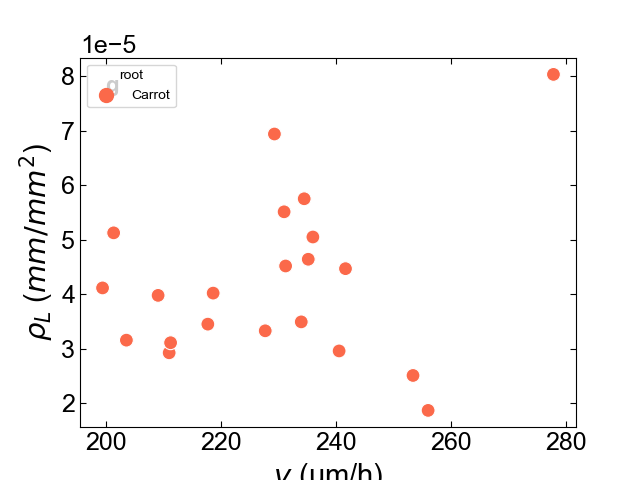

In [5]:
fig,ax = plt.subplots()
(x_col, y_col, label,xlabel,ylabel) =('speed', 'density_BV', 'g', '$v$ (um/h)', r'$\rho_L$ ($mm/mm^2$)')

plot_scatter_with_mean_and_ci(df, x_col, y_col, ax=ax, label=label)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# plt.savefig(os.path.join('figures', '0P100P.pdf'), transparent=True, bbox_inches='tight')


In [6]:
root_dir = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA"
analysis_dir = "PRINCE_ANALYSIS"
df_sum = pd.read_excel(os.path.join(root_dir, analysis_dir, "plate_summary2.xlsx"))

In [7]:
df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
df_sum['start'].unique()
df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')

C:\Users\coren\AppData\Local\Temp\ipykernel_22772\2032328214.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
C:\Users\coren\AppData\Local\Temp\ipykernel_22772\2032328214.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')


In [8]:
df_sum['age'] = df_sum['crossed']-df_sum['start']
merged_df = df.merge(df_sum, left_on='plate_id', right_on='unique_id', how='inner')
merged_df['age'] = merged_df['age'].dt.days.astype(int)


2023-11-14 15:17:50,671-[WARNING]- matplotlib.text:697 -> posx and posy should be finite values


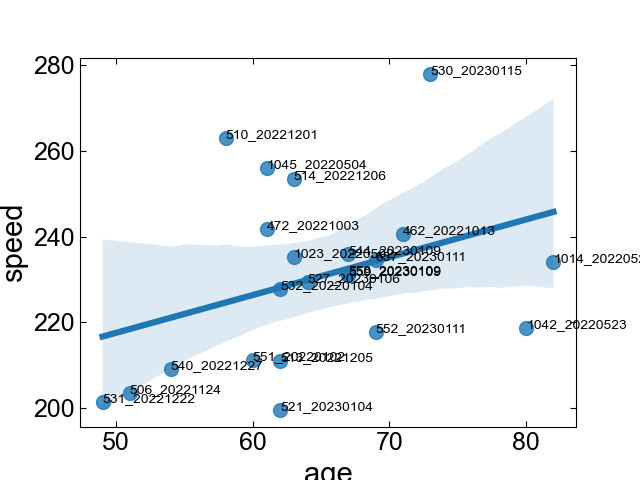

In [9]:
fig,ax = plt.subplots()
select = merged_df[merged_df['root_y']=='carrot']
# select= merged_df
sns.regplot(select,x='age',y='speed')
for index,row in select.iterrows():
    ax.text(row['age'],row['speed'],row['unique_id'])

2023-11-14 15:17:51,484-[WARNING]- matplotlib.text:697 -> posx and posy should be finite values


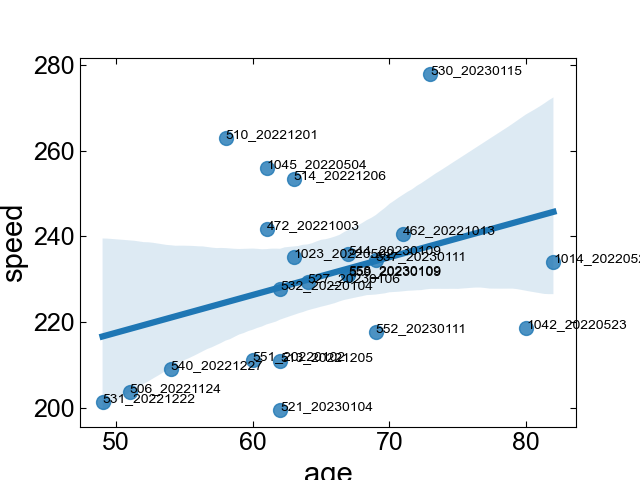

In [10]:
fig,ax = plt.subplots()
select = merged_df[merged_df['root_y']=='carrot']
# select= merged_df
sns.regplot(select,x='age',y='speed')
for index,row in select.iterrows():
    ax.text(row['age'],row['speed'],row['unique_id'])

2023-11-14 15:17:52,118-[WARNING]- matplotlib.text:697 -> posx and posy should be finite values
2023-11-14 15:17:52,130-[WARNING]- matplotlib.text:697 -> posx and posy should be finite values


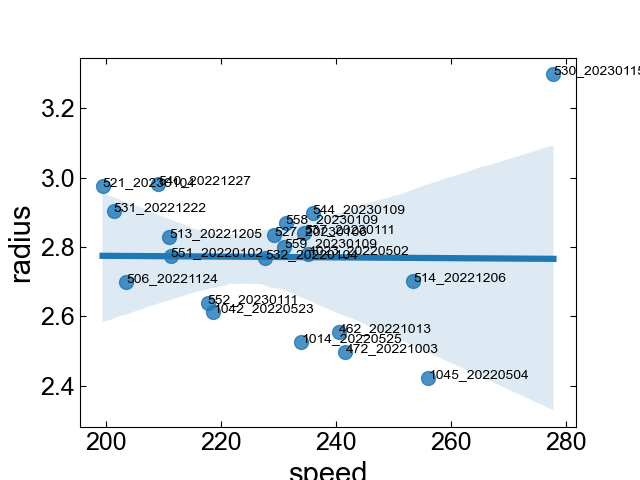

In [11]:
fig,ax = plt.subplots()
select = merged_df[merged_df['root_y']=='carrot']
# select= merged_df
sns.regplot(select,x='speed',y='radius')
for index,row in select.iterrows():
    ax.text(row['speed'],row['radius'],row['unique_id'])

2023-11-14 15:17:52,810-[WARNING]- matplotlib.text:697 -> posx and posy should be finite values
2023-11-14 15:17:52,823-[WARNING]- matplotlib.text:697 -> posx and posy should be finite values


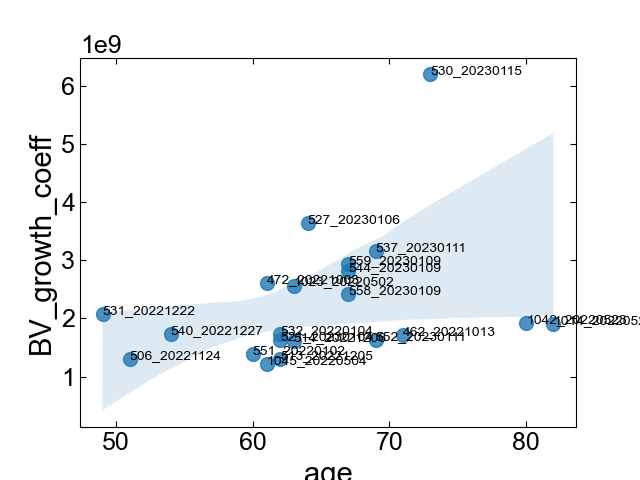

In [12]:
fig,ax = plt.subplots()
select = merged_df[merged_df['root_y']=='carrot']
# select= merged_df
sns.regplot(select,x='age',y='BV_growth_coeff')
for index,row in select.iterrows():
    ax.text(row['age'],row['BV_growth_coeff'],row['unique_id'])

In [13]:
time_plate_info['radius'] = np.sqrt(time_plate_info['tot_biovolume_study']/time_plate_info['tot_length_study']/2/np.pi)
# Initialize an empty DataFrame to hold the concatenated data
concatenated_data = []
tmax = 150

for j in range(0, len(plates)):
    
    plate_id = plates[j]
    if type(plate_start[plate_id]) == int and plate_start[plate_id] >= 20220101:
        
        plate = int(plate_id.split('_')[0])
        
        time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id'] == int(plate_id)]
        time_plate_info_plate = time_plate_info_plate.sort_values(by='time_since_begin_h')
        folders_plate = folders.loc[folders['unique_id'] == int(plate_id)]
        # time_plate_info_plate = time_plate_info_plate.loc[time_plate_info_plate['timestep'] < timestep[plate]]
        t_shift = time_plate_info_plate[time_plate_info_plate['area_sep_comp'] >= 100]['time_since_begin_h'].iloc[0]
        time_plate_info_plate['time_since_begin_h_shifted'] = time_plate_info_plate['time_since_begin_h'] - t_shift
        t_shift = time_plate_info_plate[time_plate_info_plate['area_sep_comp'] >= 1000]['time_since_begin_h'].iloc[0]
        time_plate_info_plate['time_since_begin_h_shifted_1000'] = time_plate_info_plate['time_since_begin_h'] - t_shift
        # Add the strain information to the DataFrame
        time_plate_info_plate['strain'] = plate_strain[plate_id]
        # time_plate_info_plate['is_in'] = time_plate_info_plate['timestep']<timestep[plate]
        time_plate_info_plate['ZMUV_radius'] = (time_plate_info_plate['radius']-np.mean(time_plate_info_plate['radius']))
        time_plate_info_plate['ZMUV_SA'] = (time_plate_info_plate['radius']**2-np.mean(time_plate_info_plate['radius']**2))
        
        time_plate_info_plate['strain_unique_id'] = time_plate_info_plate['strain'].astype(str) + '_' + time_plate_info_plate['unique_id'].astype(str)
        # Append this modified DataFrame to a list
        concatenated_data.append(time_plate_info_plate)

# Concatenate all the DataFrames in the list into a single DataFrame
final_data = pd.concat(concatenated_data)

# Replace -1.0 with NaN
final_data = final_data.replace(-1.0, np.nan)
bin_size = 10

final_data['time_hour_binned'] = final_data['time_since_begin_h_shifted'].astype(int)//bin_size*bin_size
final_data['strain'] = final_data['strain'].replace("'A5sp3'","'A5'")
final_data['tot_volume'] = final_data['spore_volume']+final_data['tot_biovolume_study']
final_data['time_hour_binned'] = final_data['time_since_begin_h_shifted'].astype(int)//bin_size*bin_size

select = final_data[final_data['time_since_begin_h_shifted']<=tmax]


In [14]:
plate

540

2023-11-14 15:18:03,175-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


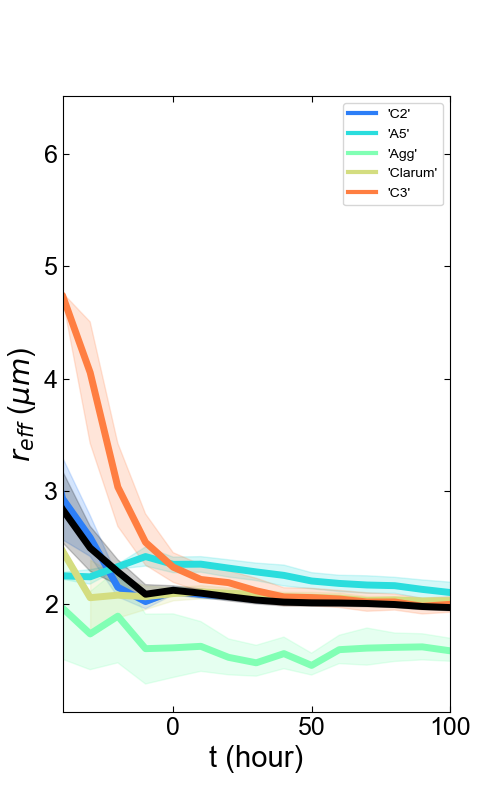

In [15]:
fig,ax = plt.subplots(figsize = (5,8))
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
# select = final_data[final_data['strain']!="'C3'"]

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(select['strain'].unique(), palette))
sns.lineplot(data=select, x='time_hour_binned', y=select['radius'], hue='strain', ax=ax, palette=strain_to_color, estimator='mean', lw=5, ls="-")
sns.lineplot(data=select, x='time_hour_binned', y=select['radius'], ax=ax, color = 'black', estimator='mean', lw=5, ls="-")
ax.set_xlabel('t (hour)')
ax.set_ylabel('$r_{eff}$ ($\mu m$)')
ax.set_xlim(-40,100)
# ax.set_ylim(1,2.5)
plt.savefig(os.path.join('figures', 'time_radius.pdf'), transparent=True, bbox_inches='tight')


(0.0, 500.0)

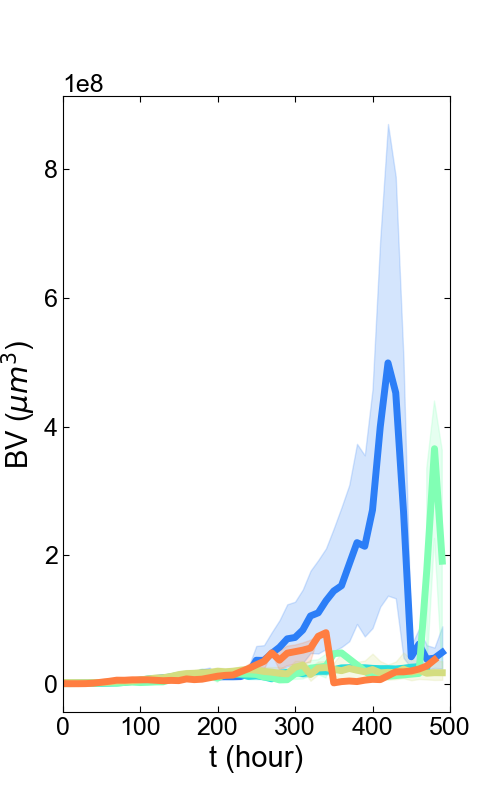

In [16]:
fig,ax = plt.subplots(figsize = (5,8))
n_colors = len(final_data['strain'].unique())
tmax = 500
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(select['strain'].unique(), palette))
# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['spore_volume'], hue='strain', ax=ax, palette=strain_to_color, estimator='mean', lw=5, ls="-")
ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
# ax.set_ylim(0,1e7)
ax.set_xlim(0,tmax)

# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


Text(0, 0.5, 'BV ($\\mu m^3$)')

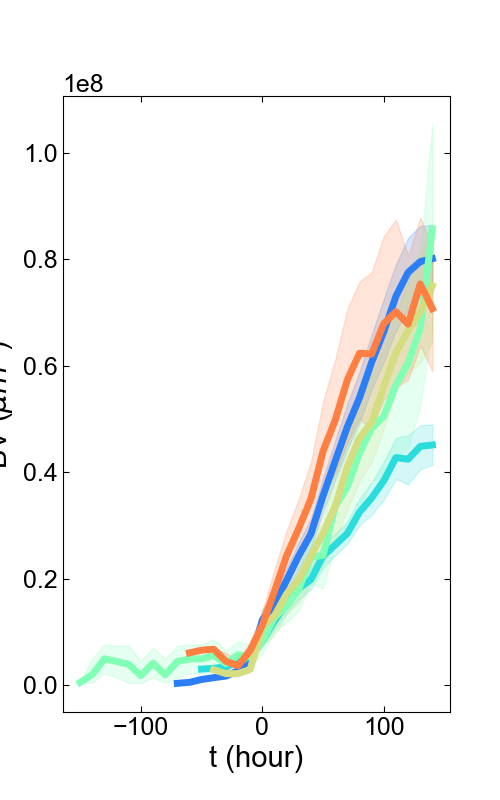

In [17]:
fig,ax = plt.subplots(figsize = (5,8))
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(select['strain'].unique(), palette))
# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['tot_biovolume_study'], hue='strain', ax=ax, palette=strain_to_color, estimator='mean', lw=5, ls="-")
ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
# ax.set_ylim(0,1e7)
# ax.set_xlim(0,tmax)

# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


In [18]:
strain_to_color

{"'C2'": (0.17058823529411765, 0.4946558433997788, 0.9667184042691874),
 "'A5'": (0.16666666666666663, 0.8660254037844386, 0.8660254037844387),
 "'Agg'": (0.503921568627451, 0.9999810273487268, 0.7049255469061472),
 "'Clarum'": (0.8333333333333333, 0.8660254037844387, 0.5000000000000001),
 "'C3'": (1.0, 0.4946558433997788, 0.2558427775944356)}

(0.0, 150.0)

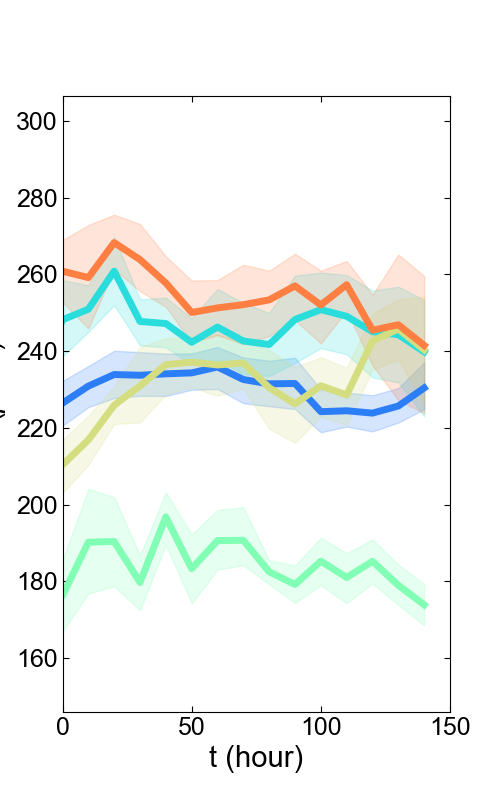

In [19]:
fig,ax = plt.subplots(figsize = (5,8))
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['hull_speed'], hue='strain', ax=ax, palette=strain_to_color, estimator='mean', lw=5, ls="-")
ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
# ax.set_ylim(0,1e8)
ax.set_xlim(0,tmax)

# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


In [20]:
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)

In [21]:
def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)

    # Calculate the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)

In [22]:

calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume', window=5)
calculate_derivative(final_data,f'tot_volume',f'derivative_tot_biovolume', window=5)

Vmax = 3e-9*25 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
respiration_ratio = 0.5
final_data['P rate'] =final_data['tot_surface_area_study']*Vmax
final_data['C rate'] = final_data['derivative_biovolume']*density*dry_wet_ratio*carbon_ratio/respiration_ratio
final_data['totC'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio


<AxesSubplot: xlabel='time_since_begin_h_shifted', ylabel='totC'>

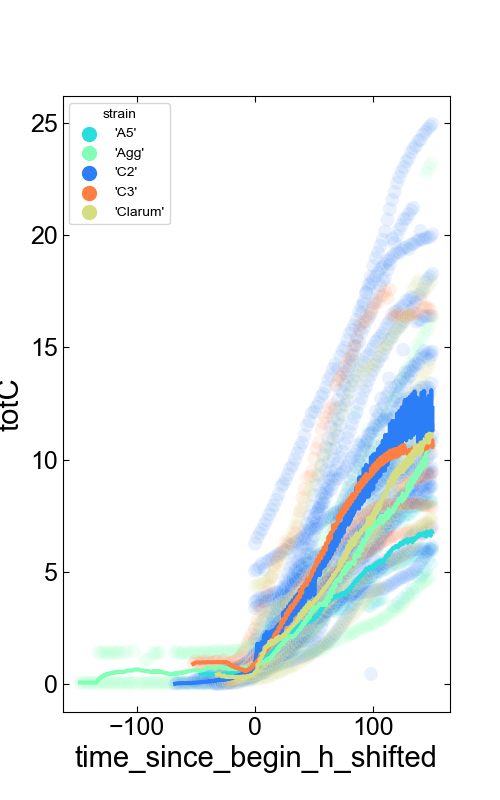

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming select DataFrame and strain_to_color dictionary already exist
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]

# Sort the data by strain and tot_surface_area_study
select = select.sort_values(by=['strain', 'time_since_begin_h_shifted'])

# Calculate moving average for each strain based on tot_surface_area_study ordering
window_size = 30
select['totC_ma'] = select.groupby('strain')['totC'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).mean())

# Plotting
fig, ax = plt.subplots(figsize=(5,8))
sns.scatterplot(data=select, x='time_since_begin_h_shifted', y='totC', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
sns.lineplot(data=select, x='time_since_begin_h_shifted', y='totC_ma', hue='strain', ax=ax, palette=strain_to_color, legend=False)  # suppress legend for lineplot
# ax.set_ylim(0,2e6)


<AxesSubplot: xlabel='time_since_begin_h_shifted', ylabel='tot_length_study'>

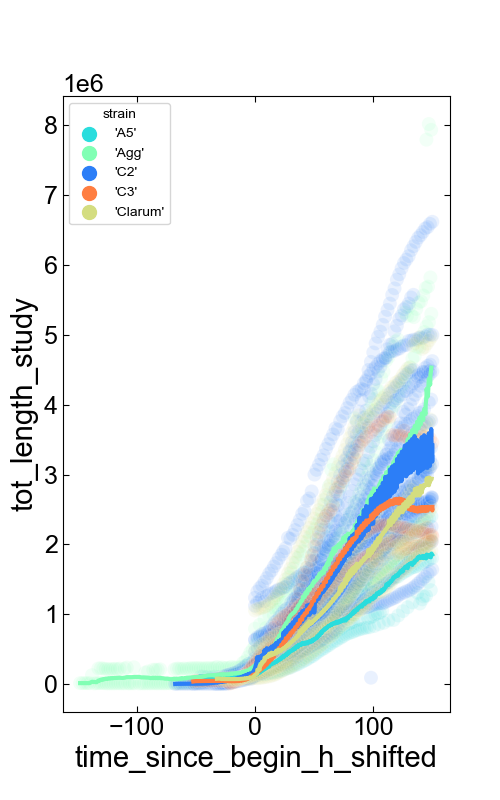

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming select DataFrame and strain_to_color dictionary already exist
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]

# Sort the data by strain and tot_surface_area_study
select = select.sort_values(by=['strain', 'time_since_begin_h_shifted'])

# Calculate moving average for each strain based on tot_surface_area_study ordering
window_size = 30
select['tot_length_study_ma'] = select.groupby('strain')['tot_length_study'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).mean())

# Plotting
fig, ax = plt.subplots(figsize=(5,8))
sns.scatterplot(data=select, x='time_since_begin_h_shifted', y='tot_length_study', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
sns.lineplot(data=select, x='time_since_begin_h_shifted', y='tot_length_study_ma', hue='strain', ax=ax, palette=strain_to_color, legend=False)  # suppress legend for lineplot
# ax.set_ylim(0,2e6)


<AxesSubplot: xlabel='time_since_begin_h_shifted_1000', ylabel='area_sep_comp'>

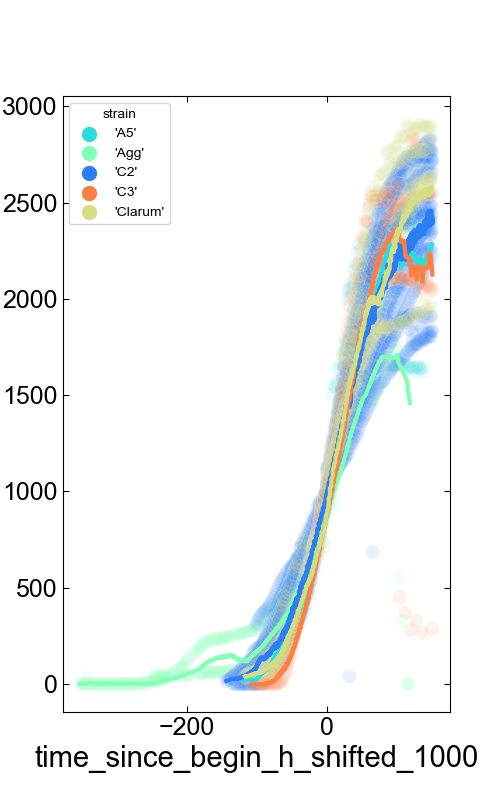

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming select DataFrame and strain_to_color dictionary already exist
select = final_data[final_data['time_since_begin_h_shifted_1000']<=tmax]

# Sort the data by strain and tot_surface_area_study
select = select.sort_values(by=['strain', 'time_since_begin_h_shifted_1000'])

# Calculate moving average for each strain based on tot_surface_area_study ordering
window_size = 30
select['area_sep_comp_ma'] = select.groupby('strain')['area_sep_comp'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).mean())

# Plotting
fig, ax = plt.subplots(figsize=(5,8))
sns.scatterplot(data=select, x='time_since_begin_h_shifted_1000', y='area_sep_comp', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
sns.lineplot(data=select, x='time_since_begin_h_shifted_1000', y='area_sep_comp_ma', hue='strain', ax=ax, palette=strain_to_color, legend=False)  # suppress legend for lineplot
# ax.set_ylim(0,2e6)


(0.0, 2000000.0)

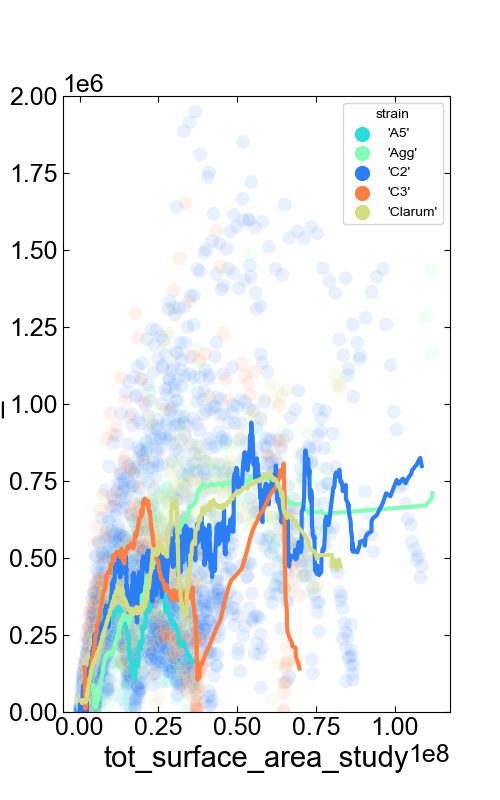

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming select DataFrame and strain_to_color dictionary already exist
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]

# Sort the data by strain and tot_surface_area_study
select = select.sort_values(by=['strain', 'tot_surface_area_study'])

# Calculate moving average for each strain based on tot_surface_area_study ordering
window_size = 30
select['ma_derivative_biovolume'] = select.groupby('strain')['derivative_biovolume'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).mean())

# Plotting
fig, ax = plt.subplots(figsize=(5,8))
sns.scatterplot(data=select, x='tot_surface_area_study', y='derivative_biovolume', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
sns.lineplot(data=select, x='tot_surface_area_study', y='ma_derivative_biovolume', hue='strain', ax=ax, palette=strain_to_color, legend=False)  # suppress legend for lineplot
ax.set_ylim(0,2e6)


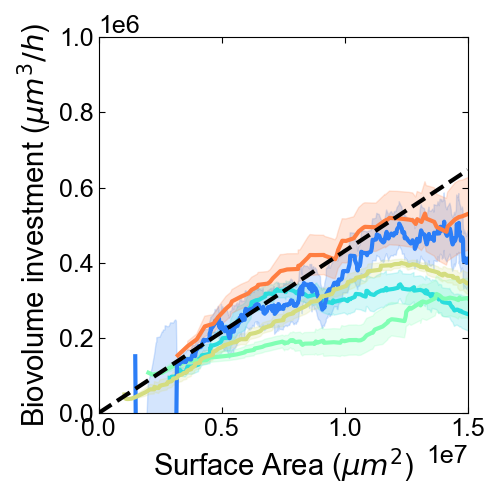

In [27]:
# 1. Separate functions for the upper and lower bounds
def compute_rolling_ci_upper(x):
    mean = x.rolling(window=window_size, min_periods=1).mean()
    std = x.rolling(window=window_size, min_periods=1).std()
    return mean + 1.96 * (std/np.sqrt(window_size))

def compute_rolling_ci_lower(x):
    mean = x.rolling(window=window_size, min_periods=1).mean()
    std = x.rolling(window=window_size, min_periods=1).std()
    return mean - 1.96 * (std/np.sqrt(window_size))
select = final_data[final_data['time_since_begin_h_shifted'].between(0,tmax)]

# Sort the data by strain and tot_surface_area_study
select = select.sort_values(by=['strain', 'tot_surface_area_study'])
window_size = 30
select['ma_derivative_biovolume'] = select.groupby('strain')['derivative_biovolume'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).mean())

# 2. Compute the upper and lower bounds separately
select['upper'] = select.groupby('strain')['derivative_biovolume'].transform(compute_rolling_ci_upper)
select['lower'] = select.groupby('strain')['derivative_biovolume'].transform(compute_rolling_ci_lower)

# Plotting (same as before)
fig, ax = plt.subplots(figsize=(5,5))
# sns.scatterplot(data=select, x='tot_surface_area_study', y='derivative_biovolume', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
sns.lineplot(data=select, x='tot_surface_area_study', y='ma_derivative_biovolume', hue='strain', ax=ax, palette=strain_to_color, legend=False)

# 3. Plot the confidence intervals
for strain, color in strain_to_color.items():
    subset = select[select['strain'] == strain]
    ax.fill_between(subset['tot_surface_area_study'], subset['lower'], subset['upper'], color=color, alpha=0.2)

ax.set_ylim(0, 1e6)
ax.set_xlim(0, 1.5e7)
unique_strains = select['strain'].unique()
slopes = []
for strain in unique_strains:
    strain_data = select[select['strain'] == strain]
    slopes += list(strain_data['ma_derivative_biovolume'] / strain_data['tot_surface_area_study'])
    
    # Get the 1% quantile slope
cutoff_slope = np.nanpercentile(slopes, 95)

# Define line endpoints based on your x-axis limits
x_vals = np.array(ax.get_xlim())
y_vals = cutoff_slope * x_vals

# Plot the line
ax.plot(x_vals, y_vals, color="black", linestyle='--', linewidth=3)
ax.set_xlabel('Surface Area ($\mu m^2$)')
ax.set_ylabel('Biovolume investment ($\mu m^3/h$)')
plt.tight_layout()

In [28]:
cz 

NameError: name 'cz' is not defined

In [ ]:
# 1. Separate functions for the upper and lower bounds
def compute_rolling_ci_upper(x):
    mean = x.rolling(window=window_size, min_periods=1).mean()
    std = x.rolling(window=window_size, min_periods=1).std()
    return mean + 1.96 * (std/np.sqrt(window_size))

def compute_rolling_ci_lower(x):
    mean = x.rolling(window=window_size, min_periods=1).mean()
    std = x.rolling(window=window_size, min_periods=1).std()
    return mean - 1.96 * (std/np.sqrt(window_size))
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]

# Sort the data by strain and tot_surface_area_study
select = select.sort_values(by=['strain', 'tot_surface_area_study'])
window_size = 30
select['ma_derivative_biovolume'] = select.groupby('strain')['derivative_tot_biovolume'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).mean())

# 2. Compute the upper and lower bounds separately
select['upper'] = select.groupby('strain')['derivative_biovolume'].transform(compute_rolling_ci_upper)
select['lower'] = select.groupby('strain')['derivative_biovolume'].transform(compute_rolling_ci_lower)

# Plotting (same as before)
fig, ax = plt.subplots(figsize=(5,8))
# sns.scatterplot(data=select, x='tot_surface_area_study', y='derivative_biovolume', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
sns.lineplot(data=select, x='tot_surface_area_study', y='ma_derivative_biovolume', hue='strain', ax=ax, palette=strain_to_color, legend=False)

# 3. Plot the confidence intervals
for strain, color in strain_to_color.items():
    subset = select[select['strain'] == strain]
    ax.fill_between(subset['tot_surface_area_study'], subset['lower'], subset['upper'], color=color, alpha=0.2)

ax.set_ylim(0, 1e6)
# ax.set_xlim(0, 1.5e7)
unique_strains = select['strain'].unique()
slopes = []
for strain in unique_strains:
    strain_data = select[select['strain'] == strain]
    slopes += list(strain_data['ma_derivative_biovolume'] / strain_data['tot_surface_area_study'])
    
    # Get the 1% quantile slope
cutoff_slope = np.nanpercentile(slopes, 95)

# Define line endpoints based on your x-axis limits
x_vals = np.array(ax.get_xlim())
y_vals = cutoff_slope * x_vals

# Plot the line
ax.plot(x_vals, y_vals, color="black", linestyle='--', linewidth=3)
ax.set_xlabel('Surface Area ($\mu m^2$)')
ax.set_ylabel('Biovolume investment ($\mu m^3/h$)')


In [ ]:
unique_strains

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming select DataFrame and strain_to_color dictionary already exist
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]

# Sort the data by strain and tot_surface_area_study

# Plotting
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=select, x='tot_surface_area_study', y='derivative_biovolume', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
select = select.sort_values(by=['tot_surface_area_study'])

# Calculate moving average for each strain based on tot_surface_area_study ordering
window_size = 70
select['quantile_derivative_biovolume'] = select['derivative_biovolume'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).quantile(0.99))
select['low_quantile_derivative_biovolume'] = select['derivative_biovolume'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).quantile(0.03))

select = select[select['tot_surface_area_study']<1e7]
# sns.regplot(data=select, x='tot_surface_area_study', y='quantile_derivative_biovolume', ax=ax, color = "black", scatter=False)  # suppress legend for lineplot
x =select['tot_surface_area_study'].values
y = select['quantile_derivative_biovolume'].values

# Regression through the origin
slope, = np.linalg.lstsq(x[:, np.newaxis], y, rcond=None)[0]

# Define your interval here. For example, from 0 to 2000.
x_interval = np.array([0, 3e7])
y_fit = slope * x_interval

ax.plot(x_interval, y_fit, color="black")
x =select['tot_surface_area_study'].values
y = select['low_quantile_derivative_biovolume'].values
# Regression through the origin
slope, = np.linalg.lstsq(x[:, np.newaxis], y, rcond=None)[0]

# Define your interval here. For example, from 0 to 2000.
x_interval = np.array([0, 7e7])
y_fit = slope * x_interval

ax.plot(x_interval, y_fit, color="black")
ax.set_ylim(0,2e6)
ax.set_xlabel('Surface Area ($\mu m^2$)')
ax.set_ylabel('Biovolume investment ($\mu m^3/h$)')
# plt.savefig(os.path.join('figures', 'surface_area_derivative_biovolume.pdf'), transparent=True, bbox_inches='tight')
plt.tight_layout()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Assuming select DataFrame and strain_to_color dictionary already exist
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]

# Sort the data by strain and tot_surface_area_study

# Plotting
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=select, x='P rate', y='C rate', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
select = select.sort_values(by=['P rate'])

# Calculate moving average for each strain based on tot_surface_area_study ordering
window_size = 70
select['quantile_C_rate'] = select['C rate'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).quantile(0.99))
select['low_quantile_C_rate'] = select['C rate'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).quantile(0.03))

select = select[select['tot_surface_area_study']<1e7]
# sns.regplot(data=select, x='tot_surface_area_study', y='quantile_derivative_biovolume', ax=ax, color = "black", scatter=False)  # suppress legend for lineplot
x =select['P rate'].values
y = select['quantile_C_rate'].values
# Regression through the origin
slope, = np.linalg.lstsq(x[:, np.newaxis], y, rcond=None)[0]

# Define your interval here. For example, from 0 to 2000.
x_interval = np.array([0, 3e7*Vmax])
y_fit = slope * x_interval

ax.plot(x_interval, y_fit, color="black")
x =select['P rate'].values
y = select['low_quantile_C_rate'].values
# Regression through the origin
slope2, = np.linalg.lstsq(x[:, np.newaxis], y, rcond=None)[0]

# Define your interval here. For example, from 0 to 2000.
x_interval = np.array([0, 7e7*Vmax])
y_fit = slope2 * x_interval

# ax.plot(x_interval, y_fit, color="black")
ax.set_ylim(0,2.5e6*density*dry_wet_ratio*carbon_ratio/respiration_ratio)
ax.set_xlim(0,3)

ax.set_xlabel('P absorption rate ($\mu g/h$)')
ax.set_ylabel('C provision rate ($\mu g/h$)')
# plt.savefig(os.path.join('figures', 'surface_area_derivative_biovolume.pdf'), transparent=True, bbox_inches='tight')
plt.tight_layout()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_data, tmax, and strain_to_color are already defined.
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = select[select['strain']=="'Agg'"]

# Plotting
n_colors = len(select['unique_id'].unique())

# select = final_data[final_data['strain']!="'C3'"]

palette2 = sns.color_palette("rainbow", n_colors)
unique_id_to_color2 = dict(zip(select['unique_id'].unique(), palette2))

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=select, x='P rate', y='C rate', hue='unique_id', ax=ax, palette=unique_id_to_color2, alpha=0.3)

for strain, group in select.groupby('strain'):
    # Compute the slopes
    slopes = group['C rate'] / group['P rate']
    
    # Get the 1% quantile slope
    critical_slope = np.nanpercentile(slopes, 95)
    
    # Plot a line with the identified slope up to the maximum 'P rate' for visualization
    max_x = group['P rate'].max()
    ax.plot([0, max_x], [0, critical_slope * max_x], color=strain_to_color[strain], lw=2)
# ax.set_ylim(0,2.5e6*density*dry_wet_ratio*carbon_ratio/respiration_ratio)
# ax.set_xlim(0,3)
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(data=select, x='time_since_begin_h_shifted', y='area_sep_comp', hue='unique_id', ax=ax, palette=unique_id_to_color2, alpha=0.3)


In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=select, x='time_since_begin_h', y='tot_surface_area_study', hue='unique_id', ax=ax, palette=unique_id_to_color, alpha=0.3)


In [ ]:
slope,slope2

In [ ]:
fig,ax = plt.subplots(figsize = (5,8))
n_colors = len(final_data['strain'].unique())
bin_size = 4

final_data['time_hour_binned'] = final_data['time_since_begin_h_shifted'].astype(int)//bin_size*bin_size
tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(select['strain'].unique(), palette))
# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['derivative_biovolume'], hue='strain', ax=ax, palette=strain_to_color, estimator='mean', lw=5, ls="-")
ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
# ax.set_ylim(0,1e8)
ax.set_xlim(0,tmax)

# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
fig,ax = plt.subplots(figsize = (5,8))
sns.histplot(data=select, x="hull_speed", hue='strain', ax=ax, palette=strain_to_color,stat= "density",common_norm=False,kde=True,element="step")
ax.set_xlabel('$v$ (um/h)')
plt.savefig(os.path.join('figures', 'speed_hist.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
select = final_data[final_data['strain']=="'C3'"]
# select = select[select['time_since_begin_h']<50]
num_unique_ids = len(select['unique_id'].unique())
num_rows = (num_unique_ids + 2) // 3  # Adjust the number of columns (3) as needed
num_cols = min(num_unique_ids, 3)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Loop through unique_id values and plot each curve in a separate subplot
for i, (unique_id, group_df) in enumerate(select.groupby('unique_id')):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    ax.plot(group_df['time_since_begin_h_shifted'], group_df['radius'], label=f'unique_id {unique_id}', marker='o', linestyle='-', markersize=5)
    ax.set_xlabel('Time Since Begin (hours)')
    ax.set_ylabel('Radius')
    ax.set_title(f'Radius vs. Time for unique_id {unique_id}')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0,100)
# Remove empty subplots if there are any
for i in range(num_unique_ids, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [ ]:
select = time_plate_info[time_plate_info['strain']=="'C2'"]
# select = select[select['time_since_begin_h']<50]
num_unique_ids = len(select['unique_id'].unique())
num_rows = (num_unique_ids + 2) // 3  # Adjust the number of columns (3) as needed
num_cols = min(num_unique_ids, 3)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Loop through unique_id values and plot each curve in a separate subplot
for i, (unique_id, group_df) in enumerate(select.groupby('unique_id')):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    ax.plot(group_df['time_since_begin_h'], group_df['density'], label=f'unique_id {unique_id}', marker='o', linestyle='-', markersize=5)
    ax2 = ax.twinx()
    ax2.plot(group_df['time_since_begin_h'], group_df['area_sep_comp'], label=f'unique_id {unique_id}', marker='o', linestyle='-', markersize=5,color="red")

    ax.legend()
    ax.grid(True)
    ax.set_ylim(1000,3000)
# Remove empty subplots if there are any
for i in range(num_unique_ids, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [ ]:
select = time_plate_info[time_plate_info['strain']=="'C2'"]
# select = select[select['time_since_begin_h']<50]
num_unique_ids = len(select['unique_id'].unique())
num_rows = (num_unique_ids + 2) // 3  # Adjust the number of columns (3) as needed
num_cols = min(num_unique_ids, 3)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Loop through unique_id values and plot each curve in a separate subplot
for i, (unique_id, group_df) in enumerate(select.groupby('unique_id')):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    ax.plot(group_df['time_since_begin_h'], group_df['density'], label=f'unique_id {unique_id}', marker='o', linestyle='-', markersize=5)
    ax2 = ax.twinx()
    ax2.plot(group_df['time_since_begin_h'], group_df['hull_speed'], label=f'unique_id {unique_id}', marker='o', linestyle='-', markersize=5,color="red")

    ax.legend()
    ax.grid(True)
    ax.set_ylim(1000,3000)
# Remove empty subplots if there are any
for i in range(num_unique_ids, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()